# Modelo Híbrido

Los sistemas de detección de intrusiones se pueden clasificar en basados en firmas o en anomalías. Los basados en firmas tienen la desventaja de no poder detectar vulnerabilidades zero-day, mientras que los basados en anomalías producen muchos falsos positivos. Para proporcionar una detección más amplia y precisa ambos métodos se complementan, formando un IDS híbrido.

A continuación se propone un sistema que combine las salidas de los modelos desarrollados en los apartados anteriores. Los modelos seleccionados de cada método fueron el *Autoencoder* y el *Random Forest*. Se ha elegido esta última en vez de la red neuronal debido a la diferencia entre sus salidas. RF detecta mejor las anomalías, en general que AE, y este último puede ayudar en la detección de tráfico normal.

## Librerías necesarias

In [1]:
from sklearn.metrics import accuracy_score
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from numpy import argmax
from joblib import load
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import itertools
def plot_confusion_matrix(cm, title, classes=['normal', 'abnormal'], save=False, save_as='MyFigure.png', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(save_as, dpi=100)

## Diseño del Modelo

Para realizar la combinación de los modelos se ha utilizado una estrategia de *Stacking*. La idea general es que hay diversas capas (o niveles) de clasificadores y cada capa utiliza los resultados obtenidos por la anterior. La última capa está formada por un único clasificador que es el que toma la decisión final, en este caso un *Logistic Regression*.

### Funcionamiento

El sistema ingiere el flujo ya preprocesado (22 características) y se toma como *input* en los dos modelos, con la diferencia de que el AE realiza una etapa más de preprocesado en la cual elimina 12 características del flujo de entrada. Después, ambos realizan su predicción sobre el flujo introducido, y estas se tomarán como entrada para el modelo final. Este será el que determine si el flujo introducido es una anomalía.

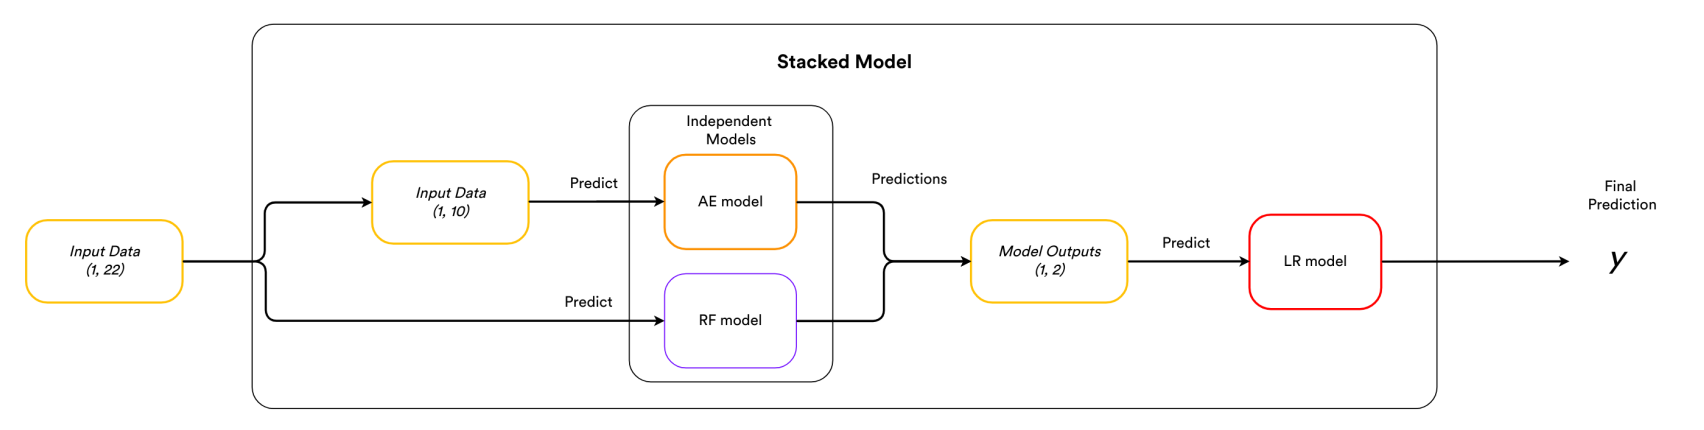

### Entrenamiento

Para realizar el proceso de entrenamiento, al modelo se le entrega un conjunto de datos (en este caso se utilizó el conjunto de *Signature Detection*). Posteriormente se le aplica un *stratified holdout* con proporción 2/3 para los modelos base (DB) y 1/3 para el modelo final (DF). El modelo de *Random Forest* se entrena con DB, y el* *Autoencoder* con un subconjunto de este, ya que utiliza 10 características de las 22.

Una vez finaliza el proceso de entrenamiento de los modelos base, estos se utilizan para predecir las salidas del conjunto DF. Las predicciones del conjunto, junto con las etiquetas de clase de DF, se utilizan para entrenar un modelo de regresión logística, que será el encargado de realizar la predicción final.

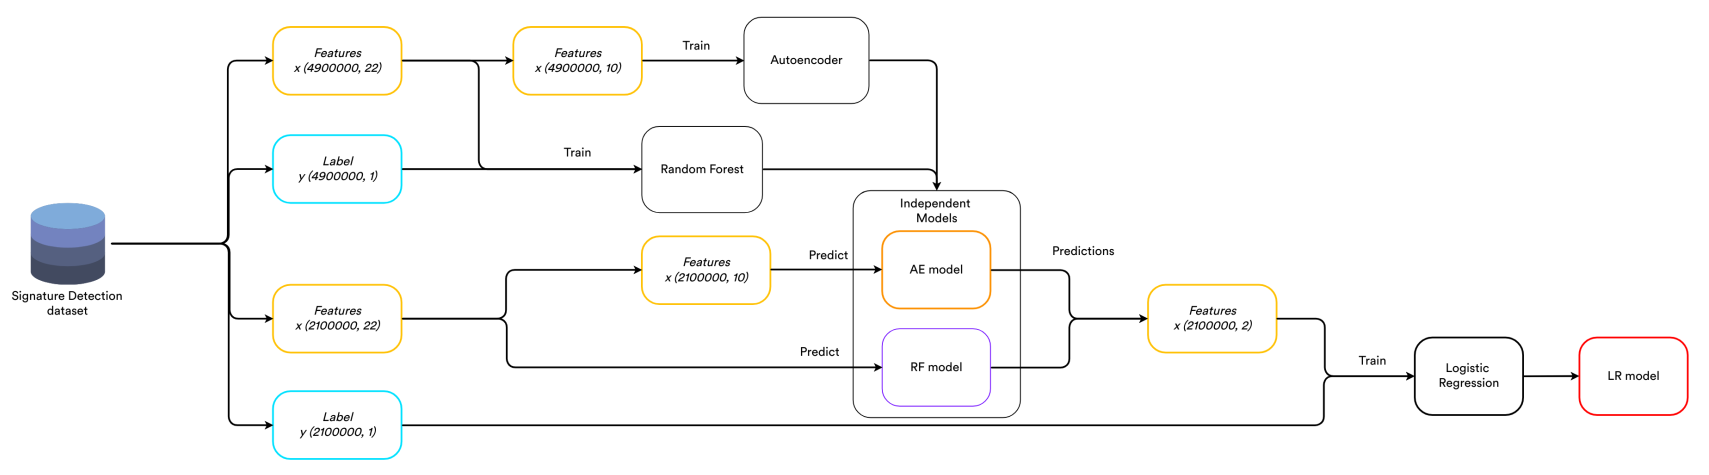

## Implementación

In [3]:
class StackedClassifier():
    
    def __init__(self):
        # Carga las arquitecturas de los modelos
        self.models = {
            'Autoencoder': load_model('/home/jovyan/My-Notebooks/Stacked/autoencoder'),
            'Random Forest' : load('/home/jovyan/My-Notebooks/Stacked/rf-hyper/RF.joblib')
            }
        # Threshold para el autoencoder
        self.th = 0.05
 
    # Devuelve las características necesarias para AE
    def __reshape_AE(self, X):
        return np.delete(X, [1,2,7,8,9,10,11,13,15,18,20,21], 1)

    # Entrenamiento de modelos base
    def __train_models(self, X_train_ae, y_train_ae, X_train_rf, y_train_rf):
        
        # Entrenamiento AE
        normal_train_data = X_train_ae[np.where(y_train_ae == 0)]
        stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
        self.models['Autoencoder'].fit(normal_train_data, normal_train_data, epochs=500, verbose=0, batch_size=512, shuffle=True, callbacks=[stop_early])
        
        # Entrenamiento RF
        self.models['Random Forest'].fit(X_train_rf, y_train_rf)
        preds_rf = self.models['Random Forest'].predict(X_train_rf)
        y_train_rf = np.where(y_train_ae > 0, 1, y_train_ae)

    # Función para generar el conjunto de datos para el modelo final con 
    # las predicciones de los modelos base
    def __stacked_dataset(self, X_stacked):
        global stackX
        stackX = 0
        
        # Salida AE
        X_ae = self.__reshape_AE(X_stacked)
        reconstructions = self.models['Autoencoder'].predict(X_ae)
        loss = tf.keras.losses.mae(reconstructions, X_ae)
        stackX = pd.DataFrame()
        stackX['AE'] = tf.math.less(self.th, loss)

        # Salida RF
        yhat = self.models['Random Forest'].predict(X_stacked)
        yhat = np.where(yhat > 0, 1, yhat).astype(bool)
        stackX['RF'] = yhat
        
        return stackX.values

    # Función para realizar un stratified cross-validation
    def kFold(self, inputx, inputy, splits):
        
        scores = []
        skfold = StratifiedKFold(n_splits = splits)
        
        for train_index, test_index in skfold.split(inputx, inputy):
            X_train, X_test = inputx[train_index], inputx[test_index]
            y_train, y_test = inputy[train_index], inputy[test_index]
            
            self.fit(X_train, y_train)
            
            scores.append(accuracy_score(y_test, self.predict(X_test)))
        
        return scores
    
    # Función de entrenamiento
    def fit(self, inputx, inputy):
        
        # Se realiza un stratified holdout sobre el conjunto de entrada, generando
        # el conjunto para los modelos base y otro para el modelo final
        X_train, X_stacked, y_train, y_stacked = train_test_split(inputx, inputy, test_size=0.33, random_state=100)
        # Se genera el conjunto reducido para AE
        X_train_ae = self.__reshape_AE(X_train)
        
        # Entrenamiento de modelos locales
        self.__train_models(X_train_ae, y_train, X_train, y_train)
        
        # Predicciones de los modelos base
        stackedX = self.__stacked_dataset(X_stacked)
        
        # Entrenamiento del modelo final
        LR = LogisticRegression()
        y_stacked = np.where(y_stacked > 0, 1, y_stacked).astype(bool)
        LR.fit(stackedX, y_stacked)
        self.stacked_model = LR
    
    # Función de predicción
    def predict(self, inputX):
        
        # Predicciones de los modelos base
        stackedX = self.__stacked_dataset(inputX) 
        # Predicciones del modelo final
        yhat = self.stacked_model.predict(stackedX)
        
        return yhat

### Carga del conjunto de datos

In [4]:
df = pd.read_csv('/home/jovyan/My-Notebooks/Data Preprocess/train-SD-reduced.csv', sep=',', low_memory=False)
y_train = df.pop('Label')
X_train = df.values

In [5]:
sc = StackedClassifier()

### Entrenamiento

In [7]:
sc.fit(X_train, y_train)

113438/113438 [==============================] - 126s 1ms/step


### Carga del conjunto de test

In [8]:
df = pd.read_csv('/home/jovyan/My-Notebooks/Data Preprocess/test-SD.csv', sep=',', low_memory=False)
y_test = df.pop('Label')
X_test = df.values

In [9]:
%%time
preds = sc.predict(X_test)

136848/136848 [==============================] - 152s 1ms/step
CPU times: user 5min 36s, sys: 36.3 s, total: 6min 12s
Wall time: 5min 6s


### Resultados
#### Matriz de confusión

              precision    recall  f1-score   support

           0    0.99204   0.97049   0.98115   3567467
           1    0.88160   0.96579   0.92178    811664

    accuracy                        0.96962   4379131
   macro avg    0.93682   0.96814   0.95146   4379131
weighted avg    0.97157   0.96962   0.97014   4379131



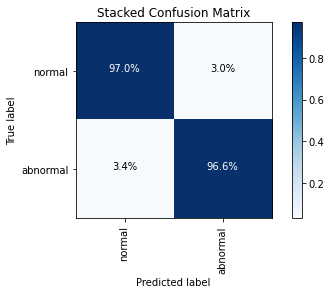

In [10]:
labels = np.where(y_test > 0, 1, y_test)
print(classification_report(labels, preds, digits=5))
cm = confusion_matrix(labels, preds)
plot_confusion_matrix(cm, title='Stacked Confusion Matrix')

#### Índices de concordancia

In [11]:
ae_pred = stackX['AE']
rf_pred = stackX['RF']
preds = preds.astype(bool)
print('Kappa Score AE-RF = {kp:.3f}.'.format(kp = cohen_kappa_score(rf_pred, ae_pred)))
print('Kappa Score RF-Stacked = {kp:.3f}.'.format(kp = cohen_kappa_score(preds, rf_pred)))
print('Kappa Score AE-Stacked = {kp:.3f}.'.format(kp = cohen_kappa_score(preds, ae_pred)))

Kappa Score AE-RF = 0.119.
Kappa Score RF-Stacked = 0.875.
Kappa Score AE-Stacked = 0.0.244.


#### Detección de los múltiples ataques

In [12]:
normal_traffic = X_test[np.where(y_test == 0)]
dos_traffic = X_test[np.where(y_test == 1)]
ddos_traffic = X_test[np.where(y_test == 2)]
bot_traffic = X_test[np.where(y_test == 3)]
bf_traffic = X_test[np.where(y_test == 4)]
inf_traffic = X_test[np.where(y_test == 5)]
web_traffic = X_test[np.where(y_test == 6)]

In [13]:
preds = sc.predict(normal_traffic)
accuracy_score(y_test[np.where(y_test == 0)[0]], preds)

111484/111484 [==============================] - 124s 1ms/step


0.9704880241358925

In [14]:
preds = sc.predict(dos_traffic)
accuracy_score(y_test[np.where(y_test == 1)[0]], preds)

5939/5939 [==============================] - 7s 1ms/step


1.0

In [15]:
preds = sc.predict(ddos_traffic)
ddos = y_test[np.where(y_test == 2)[0]]
accuracy_score(np.where(ddos > 0, 1, ddos).astype(bool), preds)

11839/11839 [==============================] - 13s 1ms/step


0.9999920807342744

In [16]:
preds = sc.predict(bot_traffic)
bot = y_test[np.where(y_test == 3)[0]]
accuracy_score(np.where(bot > 0, 1, bot).astype(bool), preds)

2677/2677 [==============================] - 3s 1ms/step


0.9996146750426192

In [17]:
preds = sc.predict(bf_traffic)
bf = y_test[np.where(y_test == 4)[0]]
accuracy_score(np.where(bf > 0, 1, bf).astype(bool), preds)

3569/3569 [==============================] - 4s 1ms/step


1.0

In [18]:
preds = sc.predict(inf_traffic)
inf = y_test[np.where(y_test == 5)[0]]
accuracy_score(np.where(inf > 0, 1, inf).astype(bool), preds)

1334/1334 [==============================] - 2s 1ms/step


0.35046039221199127

In [19]:
preds = sc.predict(web_traffic)
web = y_test[np.where(y_test == 6)[0]]
accuracy_score(np.where(web > 0, 1, web).astype(bool), preds)

9/9 [==============================] - 0s 994us/step


0.9777777777777777